In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

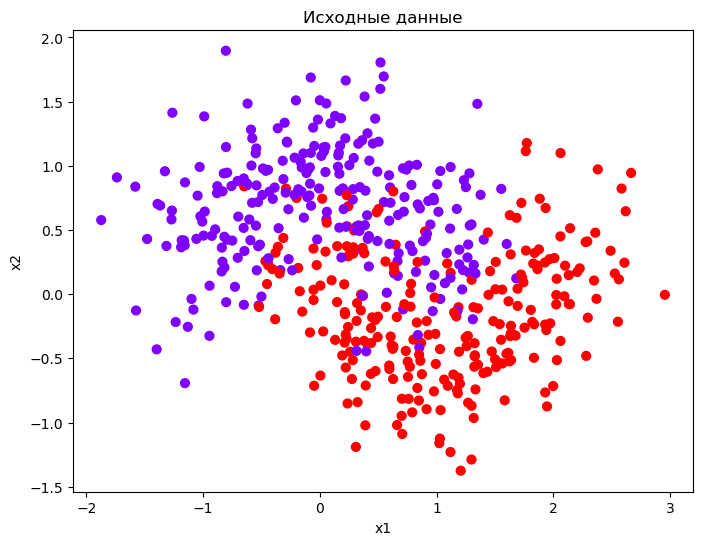

In [21]:
X, y = make_moons(n_samples=500, noise=0.35, random_state=42)  # шум увеличен

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow', s=40)
plt.title('Исходные данные')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [3]:
X_t = torch.FloatTensor(X)
y_t = torch.LongTensor(y)

In [14]:
class EfficientMLP(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, output_dim):
        super(EfficientMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

input_dim = X.shape[1]  
hidden1 = 2
hidden2 = 5
output_dim = 2  

model = EfficientMLP(input_dim, hidden1, hidden2, output_dim)

if torch.cuda.is_available():
    model = model.cuda()
    X_t = X_t.cuda()
    y_t = y_t.cuda()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

In [16]:
epochs = 300

for t in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_t)
    loss = criterion(outputs, y_t)
    loss.backward()
    optimizer.step()
    
    if t % 100 == 0:
        print(f"Epoch {t}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.6775
Epoch 100, Loss: 0.2472
Epoch 200, Loss: 0.2438


In [17]:
with torch.no_grad():
    outputs = model(X_t)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_t).float().mean()
    
print("Accuracy:", accuracy.item())

Accuracy: 0.8759999871253967


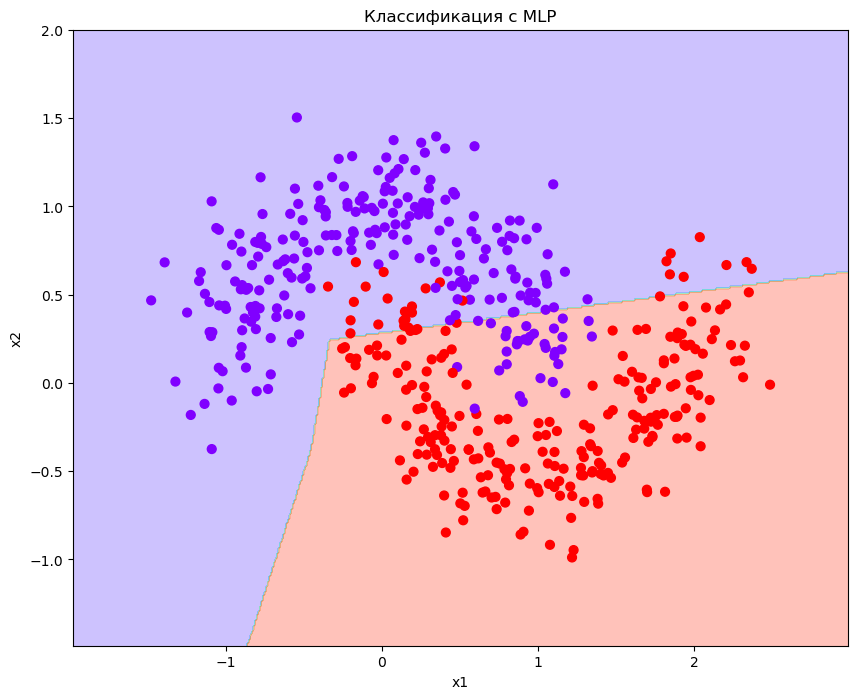

In [20]:
X_np = X_t.cpu().data.numpy() if torch.cuda.is_available() else X_t.data.numpy()
y_np = y_t.cpu().data.numpy() if torch.cuda.is_available() else y_t.data.numpy()

h = 0.01
x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_t = torch.FloatTensor(grid)
if torch.cuda.is_available():
    grid_t = grid_t.cuda()

Z = model(grid_t)
Z = Z.cpu().data.numpy() if torch.cuda.is_available() else Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, s=40, cmap=plt.cm.rainbow)
plt.title('Классификация с MLP')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()